<div style="background-color: darkslategray; color: white; padding: 15px; border-radius: 8px;">
    <center><h1 style="font-family: Arial, sans-serif;">Predicting Rare Species</h1></center>
    <center><h3 style="font-family: Arial, sans-serif;">Deep Learning Project</h3></center>
</div>

**<h3>Table of Contents</h3>**
* [1. Environment Setup](#1-environment-setup)
    * [1.1 Import Libraries](#11-import-libraries)
    * [1.2 Import Dataset](#12-import-dataset)
* [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
    * [2.1 Visualizations](#21-visualizations)
    * [2.2 Import Dataset](#22-feature-engineering)
* [3. Splitting the Dataset](#3-splitting-the-dataset)
* [4. Splitting the Dataset](#4-preprocessing)
    * [4.1 Image Generator and Augmentation](#41-image-generator-and-augmentation)


<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Import Libraries

In [22]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from classes import *
from functions import *

In [23]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC, F1Score, CategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score
from keras import optimizers


## 1.2 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [24]:
path = Path("data/rare_species")

In [25]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                                          file_path  
0         mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg  
1       chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg  
2  chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg  
3        chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg  
4        chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg

In [26]:
df.shape # 11983 images

(11983, 7)

In [27]:
# Windows
# df["full_file_path"] = df["file_path"].apply(lambda x: os.path.join(path, x.replace("/", "\\")))

# Mac
df["full_file_path"] = df["file_path"].apply(lambda x: Path(x))
df

rare_species_id  eol_content_id  eol_page_id  \
0      75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1      28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2      00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3      29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4      94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   
...                                     ...             ...          ...   
11978  1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89        29734618      1011315   
11979  628bf2b4-6ecc-4017-a8e6-4306849e0cfc        29972861      1056842   
11980  0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9        30134195     52572074   
11981  27fdb1e9-c5fb-459a-8b6a-6fb222b1c512         9474963     46559139   
11982  54894a59-151f-4814-ac32-3a336841e58e         9465817       326525   

        kingdom    phylum            family  \
0      animalia  mollusca         unionidae   
1      animalia  chordata       geoemydidae   
2      animalia  chordata  cryptobranchidae   
3      animalia  chordata          turdidae   
4      animalia  chordata         indriidae   
...         ...       ...               ...   
11978  animalia  chordata         leporidae   
11979  animalia  chordata          emydidae   
11980  animalia  chordata        dasyatidae   
11981  animalia  chordata        mustelidae   
11982  animalia  chordata         lemuridae   

                                                              file_path  \
0             mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg   
1           chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg   
2      chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg   
3            chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg   
4            chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg   
...                                                                 ...   
11978        chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg   
11979         chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg   
11980      chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg   
11981       chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg   
11982          chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg   

                                                         full_file_path  
0             mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg  
1           chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg  
2      chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg  
3            chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg  
4            chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg  
...                                                                 ...  
11978        chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg  
11979         chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg  
11980      chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg  
11981       chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg  
11982          chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg  

[11983 rows x 8 columns]

In [28]:
pd.set_option('display.max_colwidth', None)
print(df['full_file_path'])

0               mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg
1             chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg
2        chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg
3              chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg
4              chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg
                                       ...                               
11978          chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg
11979           chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg
11980        chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg
11981         chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg
11982            chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg
Name: full_file_path, Length: 11983, dtype: object


<div class="alert alert-block alert-success">

# **2.** Exploratory Data Analysis

<div>

## 2.1 Visualizations

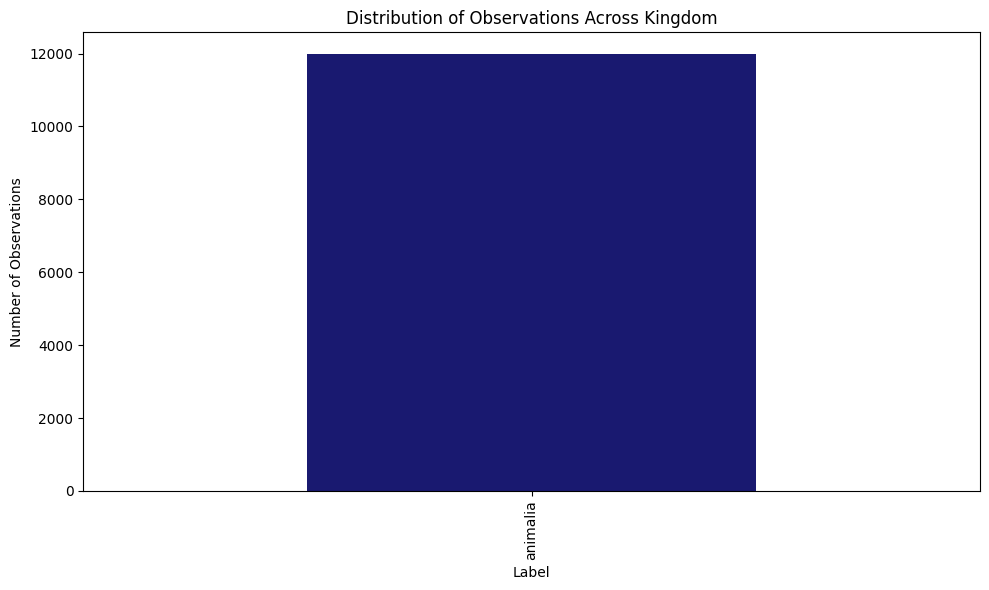

In [29]:
kingdom_counts = df['kingdom'].value_counts()
plot_graph(title='Distribution of Observations Across Kingdom', xlabel='Kingdom', ylabel='Number of Observations',  counts=kingdom_counts)

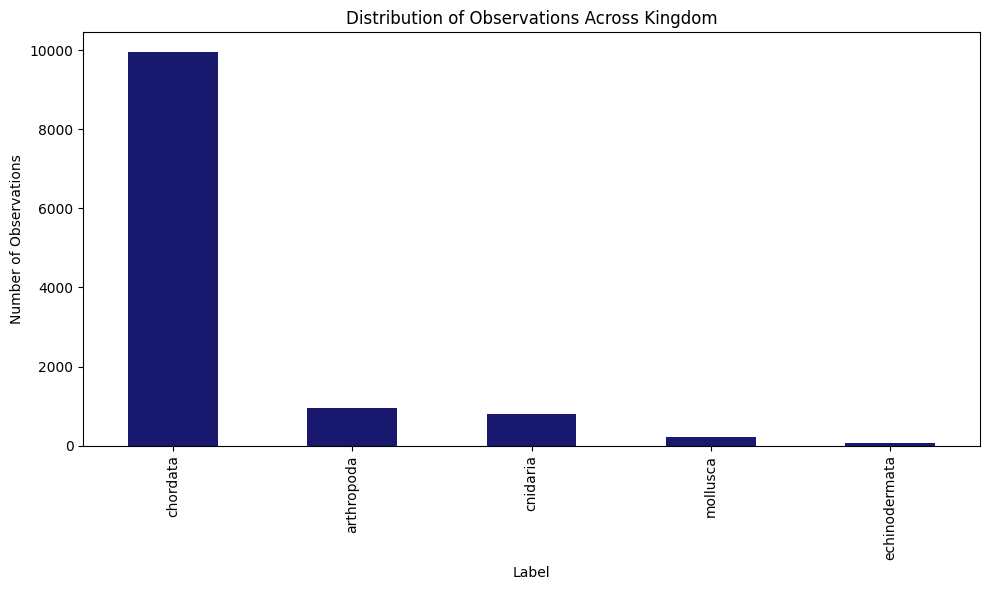

In [30]:
phylum_counts = df['phylum'].value_counts()
plot_graph(title='Distribution of Observations Across Phylum', xlabel='Phylum', ylabel='Number of Observations',  counts=phylum_counts)

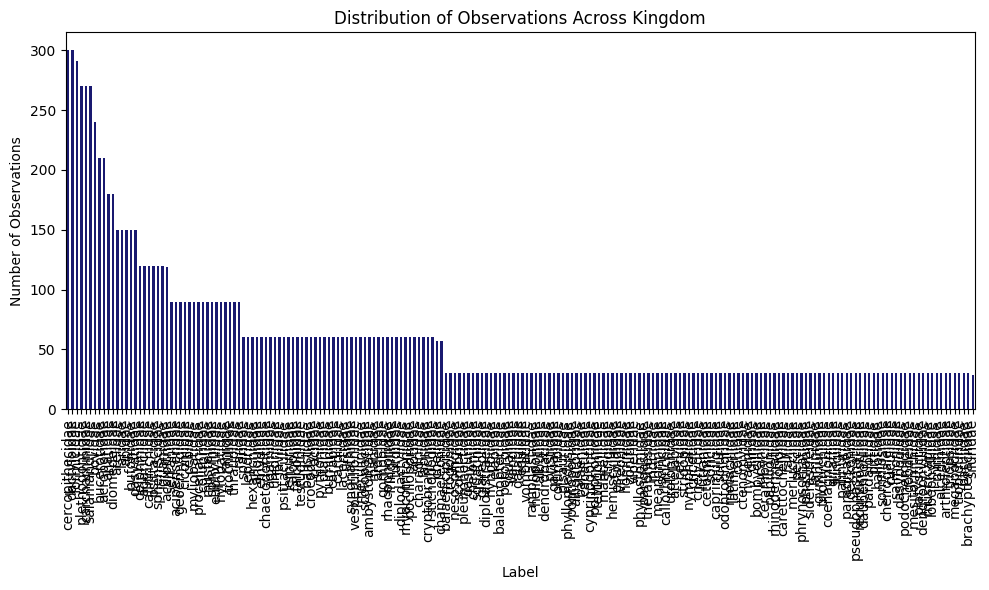

In [31]:
family_counts = df['family'].value_counts()
plot_graph(title='Distribution of Observations Across Family', xlabel='Family', ylabel='Number of Observations',  counts=family_counts)

In [32]:
family_counts = df["family"].value_counts(normalize=True)*100

df_family_proportions = pd.DataFrame({
    "Family": family_counts.index,
    "Proportion (%)": family_counts.values  
})

df_family_proportions # 202 different families

Family  Proportion (%)
0      cercopithecidae        2.503547
1          dactyloidae        2.503547
2           formicidae        2.428440
3       plethodontidae        2.253192
4       carcharhinidae        2.253192
..                 ...             ...
197       megapodiidae        0.250355
198       tropiduridae        0.250355
199          parulidae        0.250355
200  brachypteraciidae        0.250355
201          siluridae        0.242010

[202 rows x 2 columns]

In [33]:
num_families_025 = int((df_family_proportions["Proportion (%)"] <= 0.2505).sum())
num_families_025 # 118 families have less than 0.2505% of images

118

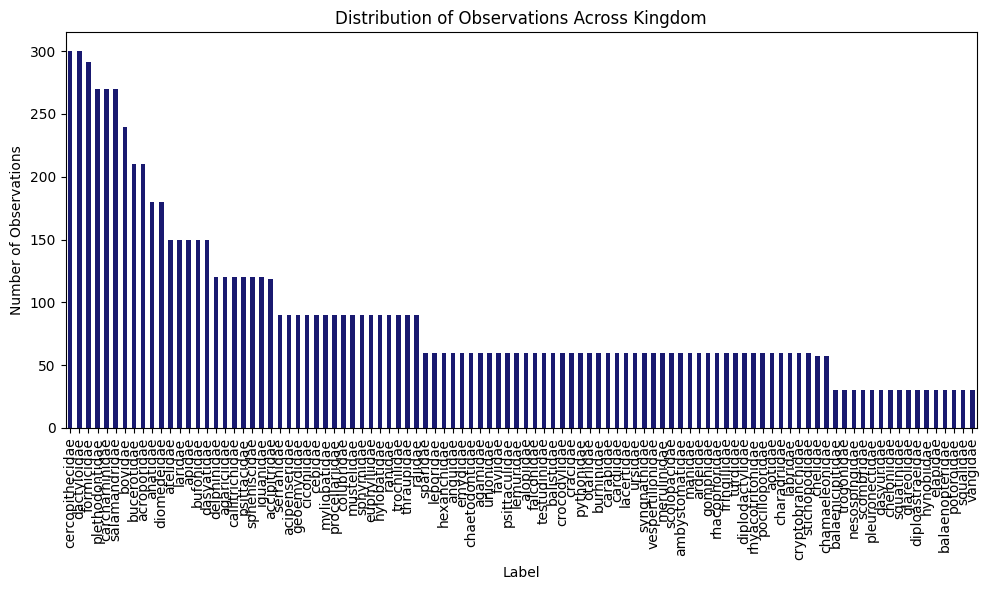

In [34]:
top_100_families = df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations Across Top 100 Families', xlabel='Family', ylabel='Number of Observations',  counts=top_100_families)

In [35]:
top_84_family_proportion_sum = df_family_proportions.iloc[:84]["Proportion (%)"].sum()
top_84_family_proportion_sum # although 118 families represent less than 0.25% of the dataset, the 84 that have >0.25% represent only 70.46% of the dataset

70.46649420011681

## 2.2 Feature Engineering

In [36]:
# is it better to predict phylum and then family or a concatenation of the two?

In [37]:
df["phylum_family"] = df["phylum"] + "_" + df["family"]
df

rare_species_id  eol_content_id  eol_page_id  \
0      75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1      28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2      00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3      29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4      94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   
...                                     ...             ...          ...   
11978  1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89        29734618      1011315   
11979  628bf2b4-6ecc-4017-a8e6-4306849e0cfc        29972861      1056842   
11980  0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9        30134195     52572074   
11981  27fdb1e9-c5fb-459a-8b6a-6fb222b1c512         9474963     46559139   
11982  54894a59-151f-4814-ac32-3a336841e58e         9465817       326525   

        kingdom    phylum            family  \
0      animalia  mollusca         unionidae   
1      animalia  chordata       geoemydidae   
2      animalia  chordata  cryptobranchidae   
3      animalia  chordata          turdidae   
4      animalia  chordata         indriidae   
...         ...       ...               ...   
11978  animalia  chordata         leporidae   
11979  animalia  chordata          emydidae   
11980  animalia  chordata        dasyatidae   
11981  animalia  chordata        mustelidae   
11982  animalia  chordata         lemuridae   

                                                              file_path  \
0             mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg   
1           chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg   
2      chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg   
3            chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg   
4            chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg   
...                                                                 ...   
11978        chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg   
11979         chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg   
11980      chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg   
11981       chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg   
11982          chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg   

                                                         full_file_path  \
0             mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg   
1           chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg   
2      chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg   
3            chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg   
4            chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg   
...                                                                 ...   
11978        chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg   
11979         chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg   
11980      chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg   
11981       chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg   
11982          chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg   

                   phylum_family  
0             mollusca_unionidae  
1           chordata_geoemydidae  
2      chordata_cryptobranchidae  
3              chordata_turdidae  
4             chordata_indriidae  
...                          ...  
11978         chordata_leporidae  
11979          chordata_emydidae  
11980        chordata_dasyatidae  
11981        chordata_mustelidae  
11982         chordata_lemuridae  

[11983 rows x 9 columns]

In [38]:
family_phylum_counts = df.groupby("phylum")["family"].nunique()

In [39]:
family_phylum_counts # the phylum with the most families is chordata

phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
Name: family, dtype: int64

In [40]:
anomaly_counts = df.groupby("family")["phylum"].nunique()

In [41]:
anomaly_counts.value_counts() # there are no families that belong to more than 1 phylum

phylum
1    202
Name: count, dtype: int64

In [42]:
phylum_family_counts = df["phylum_family"].value_counts(normalize=True)*100

df_phylum_family_proportions = pd.DataFrame({
    "phylum_family": phylum_family_counts.index,
    "Proportion (%)": phylum_family_counts.values.round(4)  
})

df_phylum_family_proportions # 202 different families

phylum_family  Proportion (%)
0      chordata_cercopithecidae          2.5035
1          chordata_dactyloidae          2.5035
2         arthropoda_formicidae          2.4284
3       chordata_plethodontidae          2.2532
4       chordata_carcharhinidae          2.2532
..                          ...             ...
197       chordata_megapodiidae          0.2504
198       chordata_tropiduridae          0.2504
199          chordata_parulidae          0.2504
200  chordata_brachypteraciidae          0.2504
201          chordata_siluridae          0.2420

[202 rows x 2 columns]

<div class="alert alert-block alert-success">

# **3.** Splitting the Dataset

<div>

In [43]:
# Split the data into training, validation, and testing sets
train_df, test_valid_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['family'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle=True, random_state=42, stratify=test_valid_df['family'])

In [44]:
image_base_path = Path("../data/rare_species")
metadata_path = image_base_path / "metadata.csv"
base_output_dir = image_base_path

In [45]:
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df, split_name="train")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=valid_df, split_name="val")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=test_df, split_name="test")

Not found: ../data/rare_species/chordata_ranidae/21985147_2920193_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_bufonidae/14130545_332433_eol-full-size-copy.jpg
Not found: ../data/rare_species/cnidaria_agariciidae/21699220_45276518_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hexanchidae/29652508_46560148_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_geoemydidae/29538706_793083_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_cervidae/15265090_308403_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hylobatidae/28175522_1038643_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_mesitornithidae/28312603_915363_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_sparidae/21866390_46580005_eol-full-size-copy.jpg
Not found: ../data/rare_species/arthropoda_formicidae/29369457_460290_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_balaenopteridae/21756543_46559441_eol-

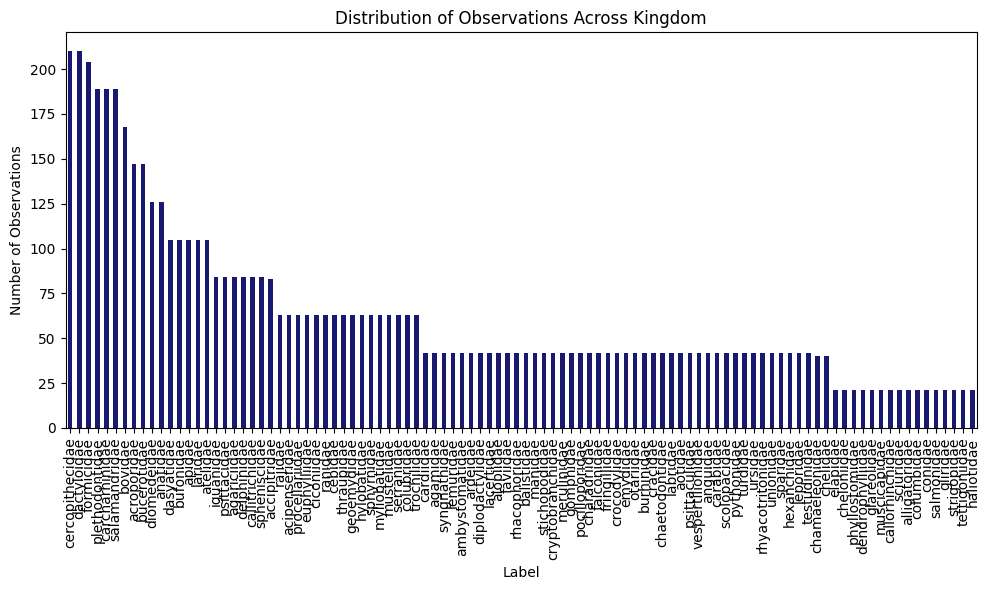

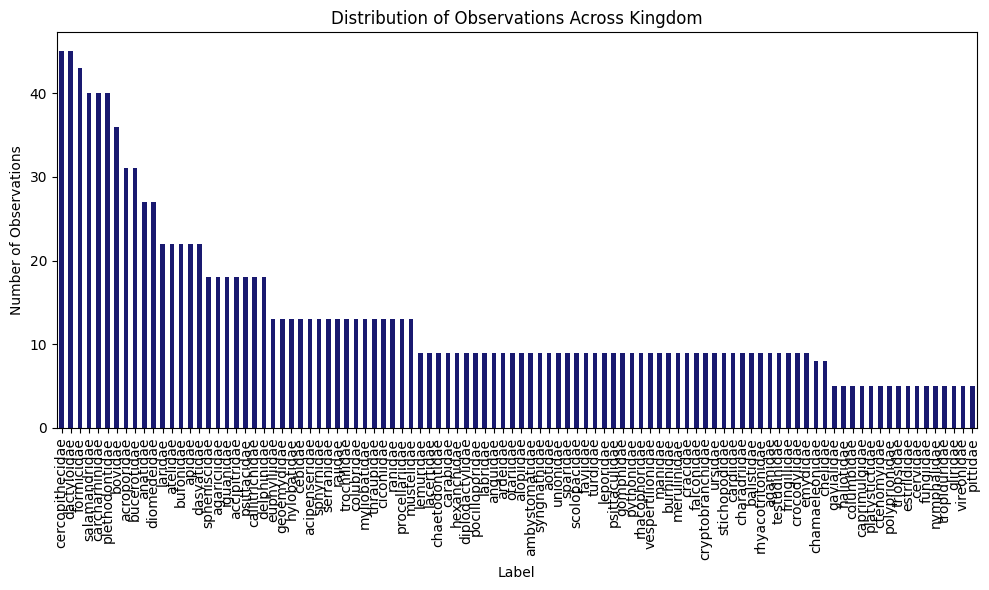

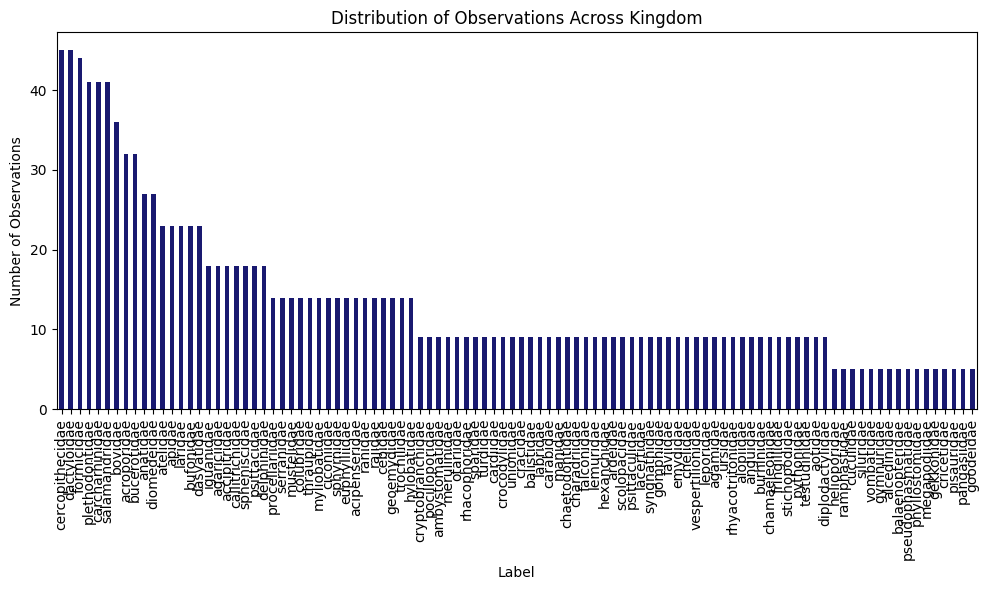

In [46]:
train_df_counts = train_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Train Dataset', xlabel='Family', ylabel='Number of Observations',  counts=train_df_counts )

valid_df_counts = valid_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Validation Dataset', xlabel='Family', ylabel='Number of Observations',  counts=valid_df_counts )

test_df_counts = test_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Test Dataset', xlabel='Family', ylabel='Number of Observations',  counts=test_df_counts )

In [47]:
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 8388
Validation samples: 1797
Testing samples: 1798


<div class="alert alert-block alert-success">

# **4.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [48]:
batch_size = 32 ## the less the better because in each epoch the model sees N / batch_size images
image_size = (224, 224) ##

preprocess = Preprocessor(image_size=image_size, batch_size=batch_size)

train_ds, class_names = preprocess.load_img(Path("../data/rare_species/train"), shuffle=False)
val_ds, _ = preprocess.load_img(Path("../data/rare_species/val"), shuffle=False)
test_ds, _ = preprocess.load_img(Path("../data/rare_species/test"), shuffle=False)

2025-04-07 17:25:30.120199: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-07 17:25:30.120233: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-07 17:25:30.120241: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-07 17:25:30.120259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-07 17:25:30.120273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


In [49]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 202), dtype=tf.float32, name=None))>

2025-04-07 17:25:35.495124: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


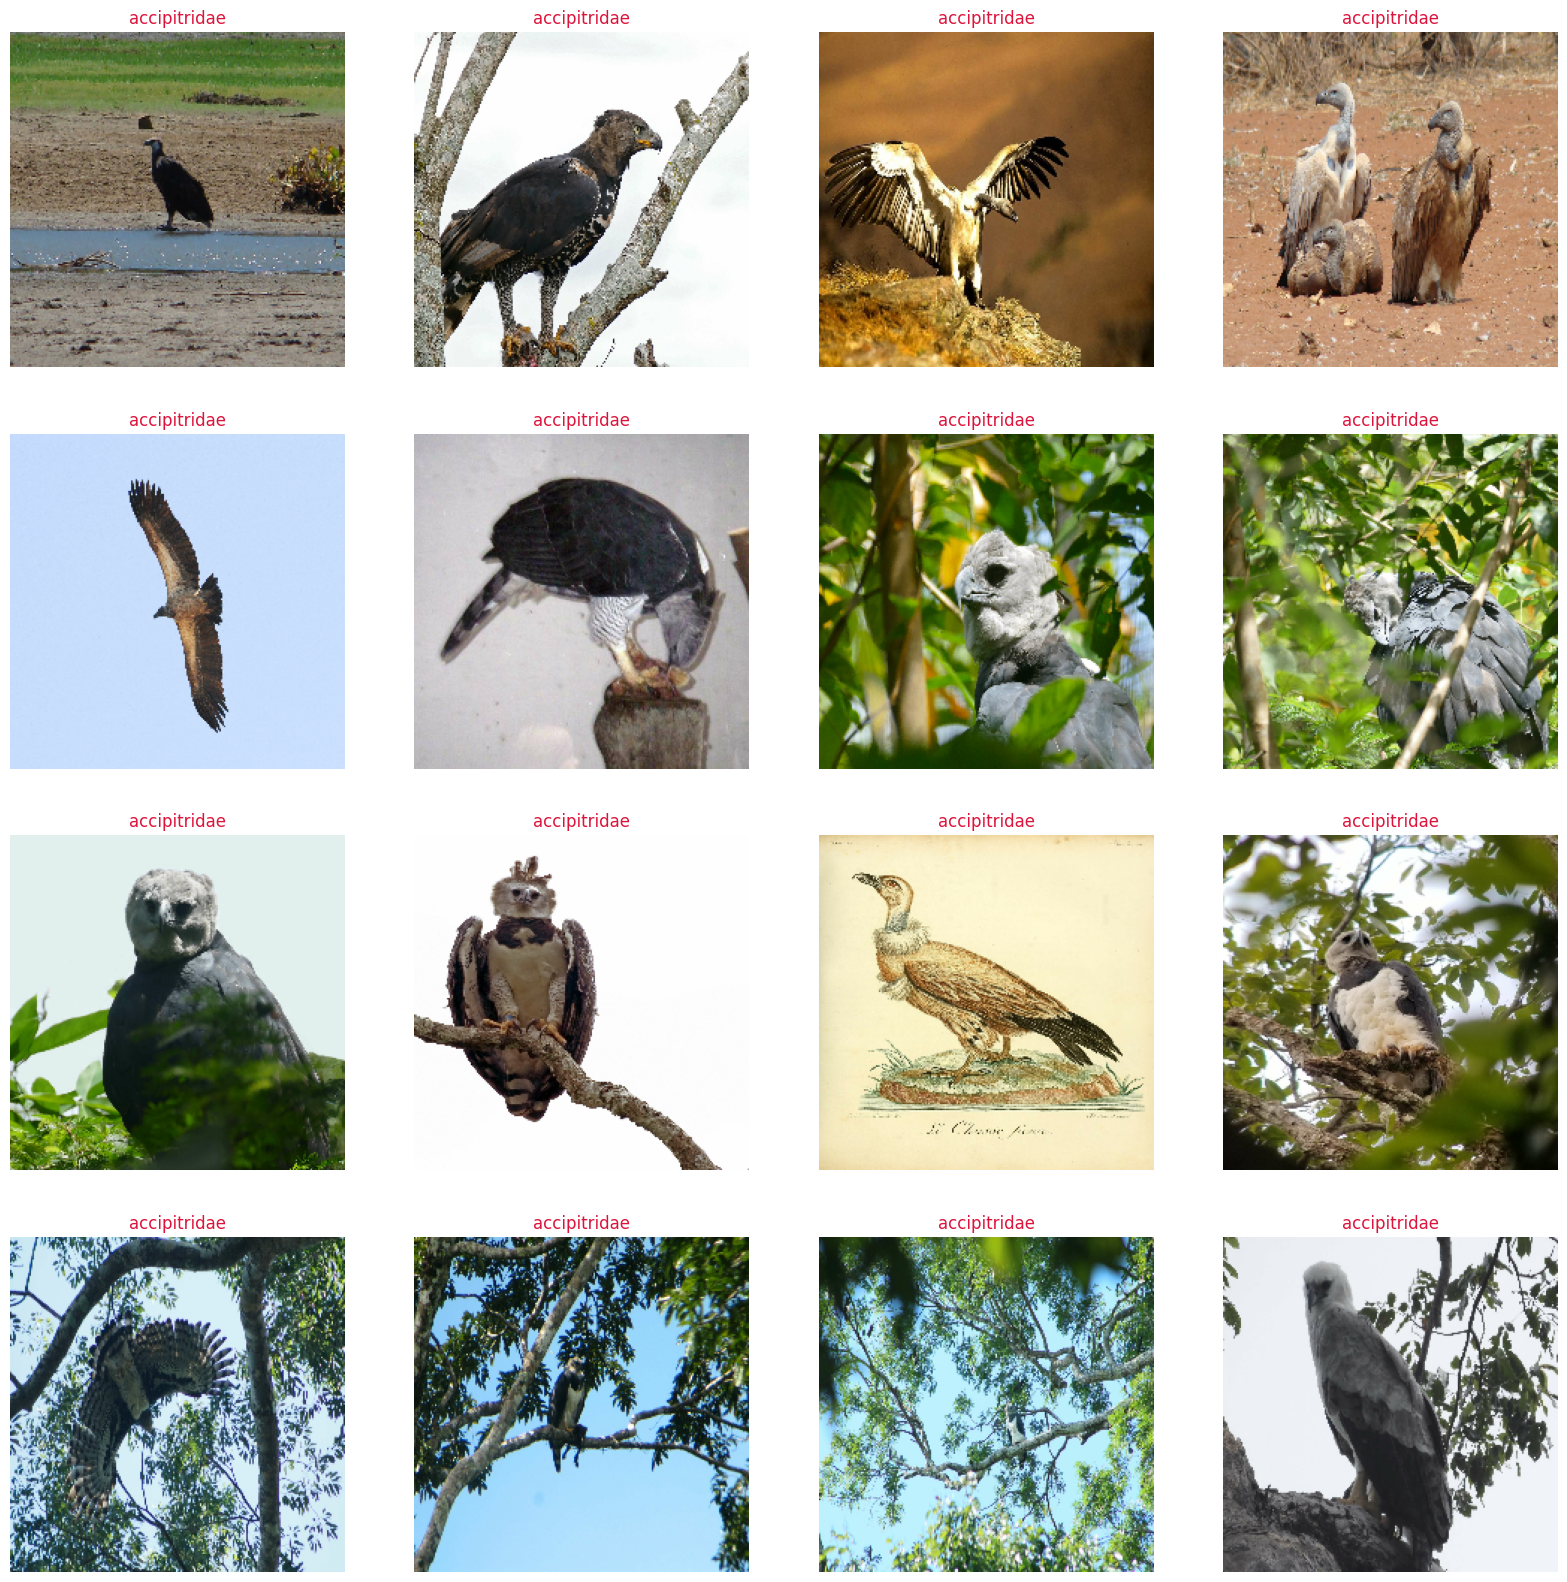

In [50]:
num_images = 16 ##
rows, cols = 4, 4 ##

plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

## 4.1 Augmentations

In [25]:
augmentations_to_test = [
    # "none",
    # "light",
    # "medium",
    # "heavy",
    # "grayscale",
    # "randaugment",
    "mixup",
    "cutmix"]

##### Simple model do test augmentations

In [26]:
def build_model(num_classes):
    base = keras.applications.EfficientNetB0(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )
    base.trainable = False  # You can fine-tune later

    inputs = keras.Input(shape=(224, 224, 3))
    x = base(inputs, training=False)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [27]:
def sample_dataset(dataset, fraction=None, num_batches=None, seed=42):
    """Return a sampled subset of the dataset."""
    if fraction:
        dataset = dataset.shuffle(1000, seed=seed)
        dataset = dataset.take(int(fraction * tf.data.experimental.cardinality(dataset).numpy()))
    elif num_batches:
        dataset = dataset.take(num_batches)
    return dataset

##### Loop

In [28]:
# Initialize the preprocessor
pre = Preprocessor(image_size=(224, 224), batch_size=32)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    # Load datasets
    train_ds, class_names = pre.load_img(
        data_dir="../data/rare_species/train",
        augment=aug
    )

    val_ds, _ = pre.load_img(
        data_dir="../data/rare_species/val",
        augment=None
    )

    # Sample a subset of training data
    train_ds = sample_dataset(train_ds, fraction=0.5)

    # Build a fresh model (you should define this function)
    model = build_sequential_model(list_of_layers=layers)

    # Compile
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        verbose=1
    )

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    results[aug] = {
        "val_accuracy": history.history["val_accuracy"][-1],
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall
    }

    print(f"Finished '{aug}'")
    print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
    print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
    print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
    print(f"  Precision:     {results[aug]['precision']:.4f}")
    print(f"  Recall:        {results[aug]['recall']:.4f}")



Training with augmentation: mixup
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.


TypeError: 'module' object is not iterable

In [ ]:
augmentations_to_test = [
    "none",
    "light",
    "medium",
    "heavy",
    "grayscale",
    "randaugment",
    "mixup",
    "cutmix"]

In [ ]:
# Initialize the preprocessor
pre = Preprocessor(image_size=(224, 224), batch_size=32)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    # Load datasets
    train_ds, class_names = pre.load_img(
        data_dir="../data/rare_species/train",
        augment=aug
    )

    val_ds, _ = pre.load_img(
        data_dir="../data/rare_species/val",
        augment=None
    )

    # Sample a subset of training data
    train_ds = sample_dataset(train_ds, fraction=0.5)

    # Build a fresh model (you should define this function)
    model = build_sequential_model(list_of_layers=layers)

    # Compile
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=15,
        verbose=1
    )

    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    results[aug] = {
        "val_accuracy": history.history["val_accuracy"][-1],
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall
    }

    print(f"Finished '{aug}'")
    print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
    print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
    print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
    print(f"  Precision:     {results[aug]['precision']:.4f}")
    print(f"  Recall:        {results[aug]['recall']:.4f}")



Training with augmentation: none
Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 21:19:16.708652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:156: Filling up shuffle buffer (this may take a while): 79 of 1000
2025-04-05 21:19:36.684879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:156: Filling up shuffle buffer (this may take a while): 238 of 1000
2025-04-05 21:19:40.175025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 79s 340ms/step - accuracy: 0.2170 - loss: 4.2472 - val_accuracy: 0.1208 - val_loss: 5.0787
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.3367 - loss: 3.6083 - val_accuracy: 0.1180 - val_loss: 5.2943
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 994s 8s/step - accuracy: 0.4475 - loss: 3.1473 - val_accuracy: 0.1258 - val_loss: 5.6601
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.5489 - loss: 2.8964 - val_accuracy: 0.1185 - val_loss: 6.1878
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy: 0.6374 - loss: 2.4828 - val_accuracy: 0.1269 - val_loss: 6.5463
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.7282 - loss: 2.1939 - val_accuracy: 0.1146 - val_loss: 7.0879
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.7490 - loss: 2.0460 - val_accuracy: 0.1269 - val_loss: 7.7286
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 975s 7s/step - accuracy: 0.8156 - loss: 1.7690 - val_acc

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 22:17:41.659241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 64 of 1000
2025-04-05 22:17:51.996033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 127 of 1000
2025-04-05 22:18:11.745928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:183: Filling up shuffle buffer (this may take a while): 260 of 1000
2025-04-05 22:18:11.906800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 344ms/step - accuracy: 0.1495 - loss: 5.9953 - val_accuracy: 0.1441 - val_loss: 5.6578
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - accuracy: 0.3079 - loss: 4.3881 - val_accuracy: 0.1419 - val_loss: 5.9899
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 299ms/step - accuracy: 0.5017 - loss: 3.5093 - val_accuracy: 0.1280 - val_loss: 6.3497
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 1016s 8s/step - accuracy: 0.6250 - loss: 3.0175 - val_accuracy: 0.1252 - val_loss: 7.1419
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.7407 - loss: 2.5342 - val_accuracy: 0.1235 - val_loss: 7.2968
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.8192 - loss: 2.2305 - val_accuracy: 0.1169 - val_loss: 7.8063
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - accuracy: 0.8618 - loss: 1.9351 - val_accuracy: 0.1169 - val_loss: 9.1001
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 288ms/step - accuracy: 0.9064 - loss: 1.7200 - val_

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 22:48:20.256006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 63 of 1000
2025-04-05 22:48:30.304556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 128 of 1000
2025-04-05 22:48:50.306837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:210: Filling up shuffle buffer (this may take a while): 252 of 1000
2025-04-05 22:48:51.698265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 1007s 7s/step - accuracy: 0.1201 - loss: 6.4720 - val_accuracy: 0.1219 - val_loss: 5.8558
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.3834 - loss: 4.3175 - val_accuracy: 0.1230 - val_loss: 6.1610
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 271ms/step - accuracy: 0.5887 - loss: 3.3520 - val_accuracy: 0.1107 - val_loss: 6.6136
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.7199 - loss: 2.8470 - val_accuracy: 0.1163 - val_loss: 7.1975
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.8256 - loss: 2.2754 - val_accuracy: 0.1035 - val_loss: 7.1223
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 286ms/step - accuracy: 0.8771 - loss: 2.0247 - val_accuracy: 0.1035 - val_loss: 7.9935
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 287ms/step - accuracy: 0.9392 - loss: 1.6427 - val_accuracy: 0.1029 - val_loss: 8.1936
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 290ms/step - accuracy: 0.9498 - loss: 1.4854 - val_

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 23:14:00.324462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:237: Filling up shuffle buffer (this may take a while): 53 of 1000
2025-04-05 23:14:10.435718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:237: Filling up shuffle buffer (this may take a while): 110 of 1000
2025-04-05 23:14:30.312030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:237: Filling up shuffle buffer (this may take a while): 225 of 1000
2025-04-05 23:14:36.699536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 339ms/step - accuracy: 0.0112 - loss: 8.5351 - val_accuracy: 0.0301 - val_loss: 5.4220
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 294ms/step - accuracy: 0.0279 - loss: 5.2140 - val_accuracy: 0.0267 - val_loss: 7.4288
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.0316 - loss: 5.1598 - val_accuracy: 0.0262 - val_loss: 6.2674
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 296ms/step - accuracy: 0.0290 - loss: 5.1016 - val_accuracy: 0.0223 - val_loss: 6.5395
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.0357 - loss: 5.0634 - val_accuracy: 0.0217 - val_loss: 7.3698
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.0393 - loss: 5.0832 - val_accuracy: 0.0173 - val_loss: 7.7884
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 293ms/step - accuracy: 0.0401 - loss: 5.0888 - val_accuracy: 0.0150 - val_loss: 9.3082
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 294ms/step - accuracy: 0.0515 - loss: 5.0266 - val

2025-04-05 23:24:26.736897: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 23:24:37.691406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:264: Filling up shuffle buffer (this may take a while): 68 of 1000
2025-04-05 23:24:47.765411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:264: Filling up shuffle buffer (this may take a while): 139 of 1000
2025-04-05 23:25:04.873381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 356ms/step - accuracy: 0.0319 - loss: 6.0261 - val_accuracy: 0.0373 - val_loss: 5.1042
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.1231 - loss: 4.7216 - val_accuracy: 0.0506 - val_loss: 5.2341
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 305ms/step - accuracy: 0.2838 - loss: 4.1143 - val_accuracy: 0.0640 - val_loss: 6.0248
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.4599 - loss: 3.4025 - val_accuracy: 0.0735 - val_loss: 6.6055
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 306ms/step - accuracy: 0.6352 - loss: 2.6594 - val_accuracy: 0.0840 - val_loss: 6.6427
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.7331 - loss: 2.2307 - val_accuracy: 0.0796 - val_loss: 6.8800
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.8260 - loss: 1.7270 - val_accuracy: 0.0851 - val_loss: 8.0222
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.8725 - loss: 1.5866 - val

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 23:35:31.937750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:291: Filling up shuffle buffer (this may take a while): 60 of 1000
2025-04-05 23:35:41.965436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:291: Filling up shuffle buffer (this may take a while): 122 of 1000
2025-04-05 23:36:01.840091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:291: Filling up shuffle buffer (this may take a while): 251 of 1000
2025-04-05 23:36:03.106872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 356ms/step - accuracy: 0.0955 - loss: 284.2841 - val_accuracy: 0.0189 - val_loss: 6.1470
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.0548 - loss: 18.8763 - val_accuracy: 0.0256 - val_loss: 6.2106
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.0501 - loss: 8.2977 - val_accuracy: 0.0022 - val_loss: 6.3709
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.0170 - loss: 7.5064 - val_accuracy: 0.0200 - val_loss: 6.3303
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.0329 - loss: 6.5946 - val_accuracy: 0.0200 - val_loss: 6.2922
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.0357 - loss: 6.3895 - val_accuracy: 0.0200 - val_loss: 6.2572
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.0373 - loss: 6.3804 - val_accuracy: 0.0200 - val_loss: 6.2240
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.0314 - loss: 6.1691 - 

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 23:46:29.976081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:318: Filling up shuffle buffer (this may take a while): 67 of 1000
2025-04-05 23:46:49.931256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:318: Filling up shuffle buffer (this may take a while): 214 of 1000
2025-04-05 23:46:56.663748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 366ms/step - accuracy: 0.0353 - loss: 5.3856 - val_accuracy: 0.0523 - val_loss: 5.0132
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 323ms/step - accuracy: 0.0687 - loss: 4.8803 - val_accuracy: 0.0568 - val_loss: 4.9252
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.1151 - loss: 4.6336 - val_accuracy: 0.0646 - val_loss: 5.0642
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 319ms/step - accuracy: 0.1681 - loss: 4.3004 - val_accuracy: 0.0607 - val_loss: 5.2859
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.2739 - loss: 3.8474 - val_accuracy: 0.0679 - val_loss: 5.3121
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.3682 - loss: 3.4304 - val_accuracy: 0.0668 - val_loss: 6.0252
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.4144 - loss: 3.1527 - val_accuracy: 0.0668 - val_loss: 6.3007
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.5232 - loss: 2.7350 - val

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15


2025-04-05 23:57:36.589133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:345: Filling up shuffle buffer (this may take a while): 69 of 1000
2025-04-05 23:57:46.602304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:345: Filling up shuffle buffer (this may take a while): 140 of 1000
2025-04-05 23:57:56.655686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:345: Filling up shuffle buffer (this may take a while): 212 of 1000
2025-04-05 23:58:03.794692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 360ms/step - accuracy: 0.1352 - loss: 5.6812 - val_accuracy: 0.0623 - val_loss: 5.3413
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - accuracy: 0.2829 - loss: 4.2820 - val_accuracy: 0.0740 - val_loss: 5.5923
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 326ms/step - accuracy: 0.4029 - loss: 3.7646 - val_accuracy: 0.0757 - val_loss: 5.7023
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 312ms/step - accuracy: 0.5039 - loss: 3.3713 - val_accuracy: 0.0751 - val_loss: 6.0000
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.6288 - loss: 2.9736 - val_accuracy: 0.0684 - val_loss: 6.1162
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 308ms/step - accuracy: 0.6861 - loss: 2.8230 - val_accuracy: 0.0757 - val_loss: 6.1896
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.7361 - loss: 2.6021 - val_accuracy: 0.0746 - val_loss: 6.4467
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 309ms/step - accuracy: 0.7649 - loss: 2.3825 - val

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4.2 Class Imbalance

<div class="alert alert-block alert-success">

# **5.** Models

<div>

## Sequential

In [31]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dense(202, activation="softmax")
          ]

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
first_sequential_model = build_sequential_model(list_of_layers=layers)
first_sequential_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,890 (84.99 MB)

 Trainable params: 22,278,890 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
n_epochs = 1 ##
batch_size = 32 ##
initial_lr = 0.01 ##
final_lr = 0.001 ##

verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [61]:
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
    lr_scheduler=my_scheduler_fn
)


In [62]:

first_sequential_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= metrics)
history = first_sequential_model.fit(train_ds, epochs= n_epochs, verbose= 1, batch_size = batch_size, validation_data= val_ds, callbacks=callbacks)

NameError: name 'first_sequential_model' is not defined

In [35]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=n_epochs, train_acc=acc_train, val_acc=acc_val)

TypeError: plot_model_acc() got an unexpected keyword argument 'train_acc'

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_loss(num_epochs=n_epochs, train_loss=loss_train, val_loss=loss_val)

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## ResNet50 - Margarida

In [51]:
verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
)

In [ ]:
base_model=ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(202, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss='categorical_crossentropy', metrics=metrics)
with tf.device('/device:GPU:0'):
      history = model.fit(train_ds, epochs=5, batch_size=64, validation_data=(val_ds), callbacks=callbacks)


Epoch 1/5


/Users/margaridabravocardoso/venvs/deep_learning_venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_acc(num_epochs=5, train_loss=loss_train, train_val=loss_val)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## Sequential - mudámos os filtros

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(24, (3, 3), activation="relu", input_shape=(224, 224, 3))) # 32 filters. 3*something
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.5)) 

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(202, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', 
              metrics= ['accuracy'])

In [ ]:
epochs=5
history = model.fit(train_generator, epochs= epochs, verbose= 1, batch_size = 20, validation_data= valid_generator)

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training accuracy')
plt.plot(xaxis, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)